In [2]:
symbol = input("Enter the symbol : ")

Enter the symbol :  AMBUJACEM


In [3]:
from nse import *
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
today = datetime.now()
oneyearago = today - timedelta(days=365*10)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()


,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2013-07-29,AMBUJACEM,EQ,179.65,168.40,178.05,171.15,170.80,178.05,2810933,4.816691e+08,223.0,162.25
1,2013-07-30,AMBUJACEM,EQ,170.75,166.35,170.75,167.85,168.80,171.15,1920388,3.229394e+08,223.0,162.25
2,2013-07-31,AMBUJACEM,EQ,169.50,164.20,167.40,167.50,168.80,167.85,2935707,4.893354e+08,223.0,162.25
3,2013-08-01,AMBUJACEM,EQ,173.70,163.25,168.90,167.45,166.60,167.50,5122210,8.642189e+08,223.0,162.25
4,2013-08-02,AMBUJACEM,EQ,173.90,167.10,168.00,171.30,171.15,167.45,3977223,6.827565e+08,223.0,162.25


In [5]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price', 'Total Traded Quantity']]
df.columns = ['Date','high', 'low', 'open','close', 'volume']
df.head()


,Date,high,low,open,close,volume
0,2013-07-29,179.65,168.40,178.05,171.15,2810933
1,2013-07-30,170.75,166.35,170.75,167.85,1920388
2,2013-07-31,169.50,164.20,167.40,167.50,2935707
3,2013-08-01,173.70,163.25,168.90,167.45,5122210
4,2013-08-02,173.90,167.10,168.00,171.30,3977223


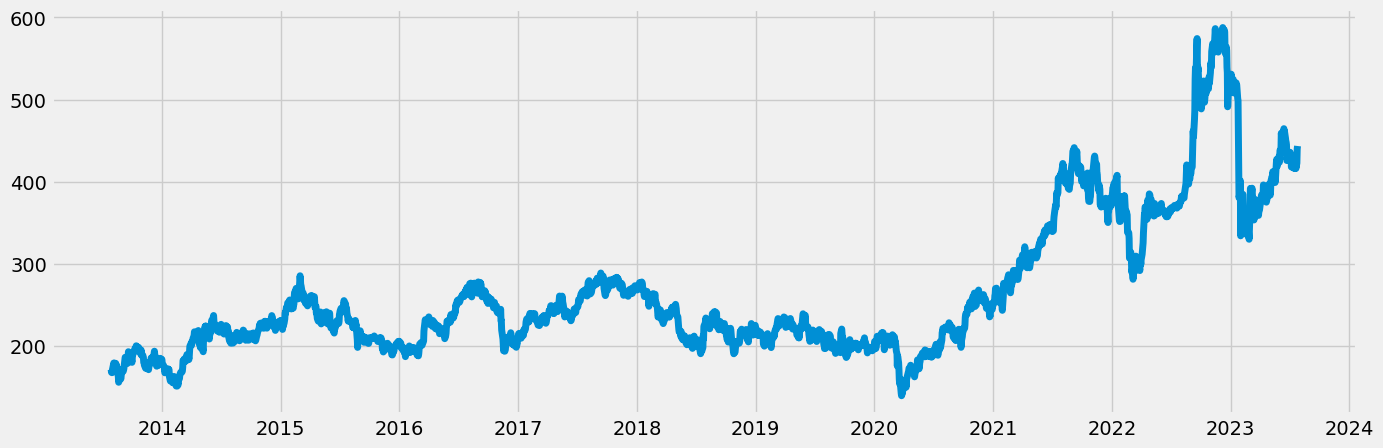

In [6]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df['Date'],df['close'],label="Close", linestyle="-", linewidth=5)

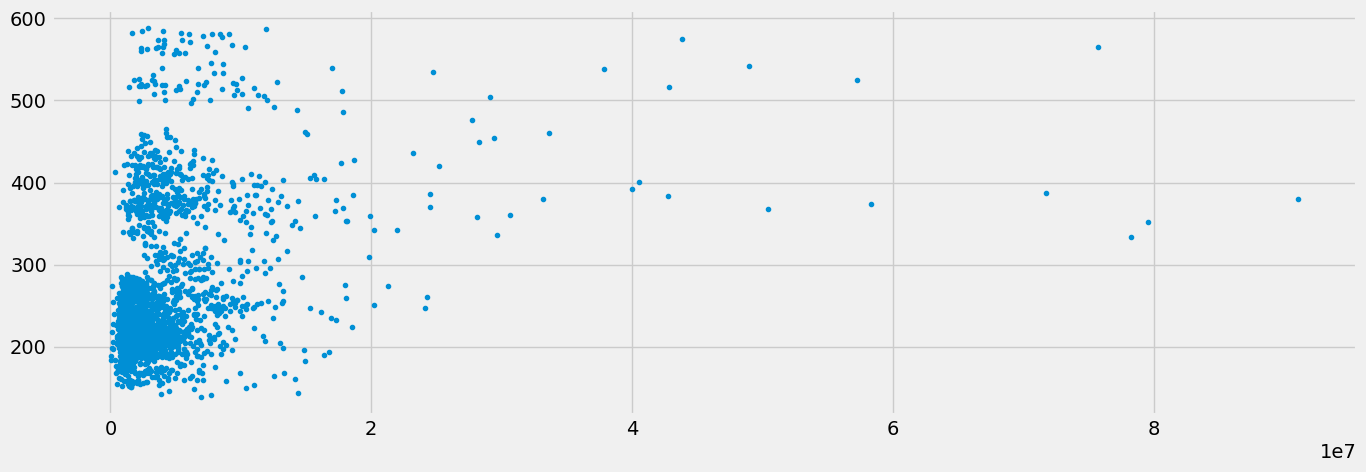

In [7]:
plt.plot(df['volume'],df['close'],linestyle="", marker=".")

In [8]:
import ta
def atr_crossover(df, sensitivity=2, atr_period=1):
    xATR = ta.volatility.average_true_range(df["high"], df["low"], df["close"], window=atr_period)

    nLoss = sensitivity * xATR

    src = df['close']

    xATRTrailingStop = pd.Series(np.zeros(len(src)))
    for i in range(1, len(src)):
        if src[i] > xATRTrailingStop[i-1] and src[i-1] > xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = max(xATRTrailingStop[i-1], src[i] - nLoss[i])
        elif src[i] < xATRTrailingStop[i-1] and src[i-1] < xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = min(xATRTrailingStop[i-1], src[i] + nLoss[i])
        elif src[i] > xATRTrailingStop[i-1]:
            xATRTrailingStop[i] = src[i] - nLoss[i]
        else:
            xATRTrailingStop[i] = src[i] + nLoss[i]

    pos = pd.Series(np.zeros(len(src)))
    for i in range(1, len(src)):
        if src[i-1] < xATRTrailingStop[i-1] and src[i] > xATRTrailingStop[i-1]:
            pos[i] = 1
        elif src[i-1] > xATRTrailingStop[i-1] and src[i] < xATRTrailingStop[i-1]:
            pos[i] = -1
        else:
            pos[i] = pos[i-1]

    ema = src.ewm(span=1, adjust=False).mean()
    above = ema > xATRTrailingStop
    below = ema < xATRTrailingStop

    buy = (src > xATRTrailingStop) & above
    sell = (src < xATRTrailingStop) & below

    df["atr_buy"] = buy
    df["atr_sell"] = sell


    # barbuy = src > xATRTrailingStop
    # barsell = src < xATRTrailingStop

    return df

def chandelier_exit(df, atr_period=22, mult=3.0, useClose=True):
    atr = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=atr_period)
    
    if useClose:
        longStop = df['close'].rolling(window=atr_period).max() - atr
        shortStop = df['close'].rolling(window=atr_period).min() + atr
    else:
        longStop = df['high'] - (atr * mult)
        shortStop = df['low'] + (atr * mult)

    buySignal = df['close'] > longStop
    sellSignal = df['close'] < shortStop

    df["ce_buy"] = buySignal
    df["ce_sell"] = sellSignal

    return df

In [9]:
newdf = df.copy()

In [10]:
atr_crossover(newdf, sensitivity=2, atr_period=1)

chandelier_exit(newdf, atr_period=22, mult=3.0)

,Date,high,low,open,close,volume,atr_buy,atr_sell,ce_buy,ce_sell
0,2013-07-29,179.65,168.40,178.05,171.15,2810933,True,False,False,False
1,2013-07-30,170.75,166.35,170.75,167.85,1920388,True,False,False,False
2,2013-07-31,169.50,164.20,167.40,167.50,2935707,True,False,False,False
3,2013-08-01,173.70,163.25,168.90,167.45,5122210,True,False,False,False
4,2013-08-02,173.90,167.10,168.00,171.30,3977223,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2476,2023-07-20,423.55,418.55,420.05,420.90,2876080,False,True,False,True
2477,2023-07-21,419.50,415.30,419.40,416.10,1990506,False,True,False,True
2478,2023-07-24,428.80,415.45,417.00,422.75,3203223,False,True,False,True
2479,2023-07-25,441.90,423.15,423.15,440.10,6432788,True,False,True,False


(264.7, 587.75)

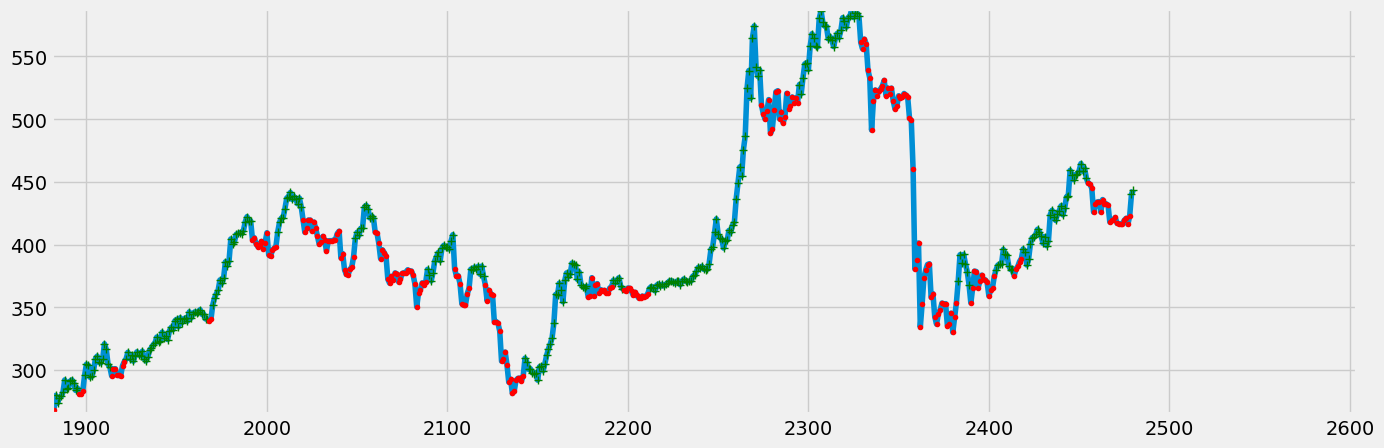

In [11]:
plt.plot(newdf["close"])
plt.plot(newdf["atr_buy"]*newdf["close"], "g +")
plt.plot(newdf["atr_sell"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))

(264.7, 587.75)

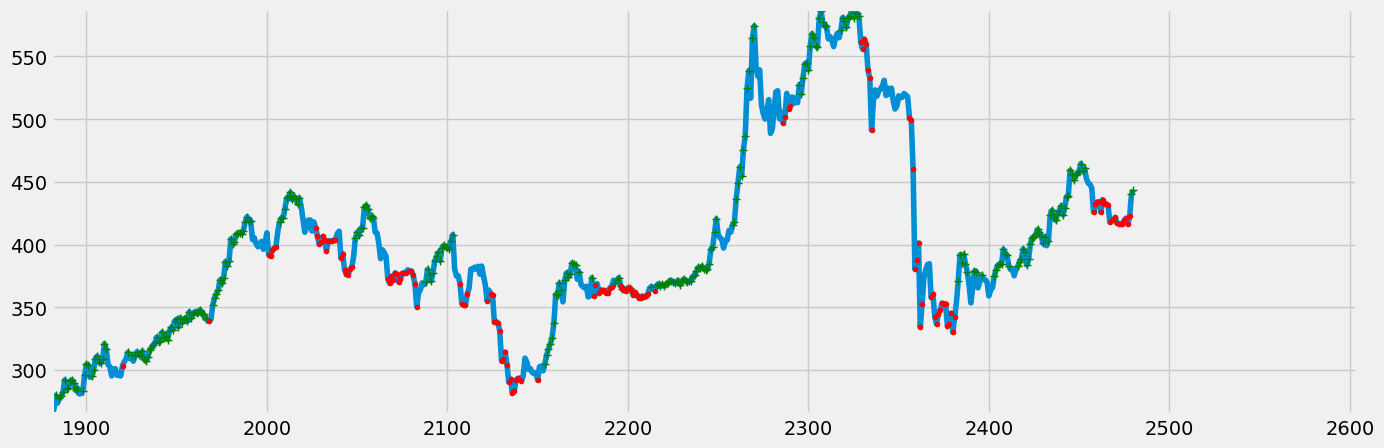

In [12]:
plt.plot(newdf["close"])
plt.plot(newdf["ce_buy"]*newdf["close"], "g +")
plt.plot(newdf["ce_sell"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))

In [13]:
indicator = []

for row in newdf[["atr_buy","atr_sell","ce_buy","ce_sell"]].iterrows():
    atr_buy,atr_sell,ce_buy,ce_sell = row[1]
    if atr_buy | ce_buy:
        indicator.append(1)
    elif atr_sell | ce_sell:
        indicator.append(-1)
    else:
        indicator.append(0)

newdf["combineindicator"] = indicator

currbuy = 0
indicator = []
for row in newdf["combineindicator"]:
    if row == currbuy:
        indicator.append(0)
    elif row == 1:
        indicator.append(1)
    elif row == -1:
        indicator.append(-1)
    else:
        indicator.append(0)

    currbuy = row
        
newdf["indicator"] = indicator

(264.7, 587.75)

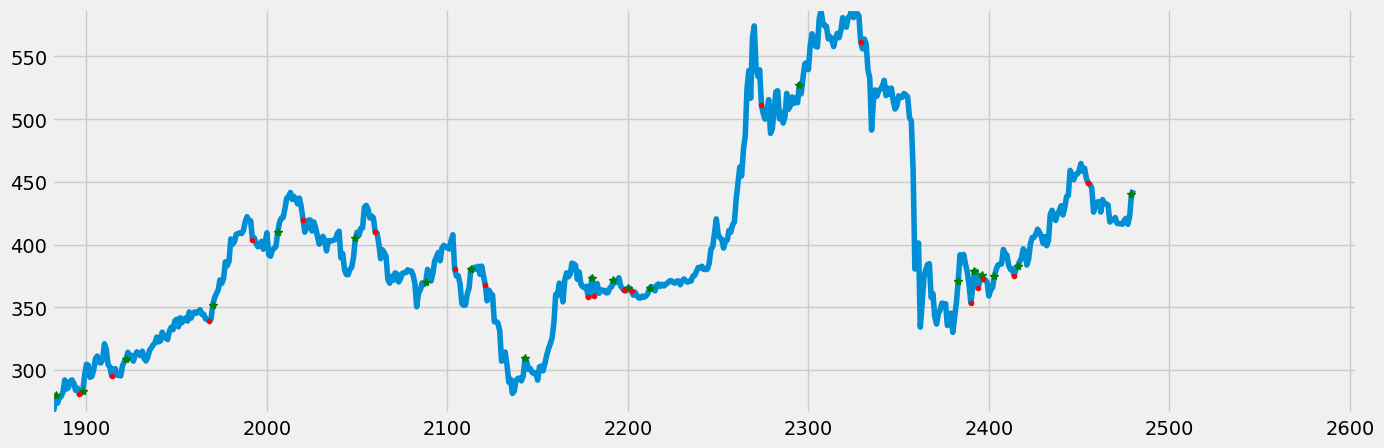

In [14]:
plt.plot(newdf["close"])
plt.plot(newdf["indicator"]*newdf["close"], "g *")
plt.plot(-1*newdf["indicator"]*newdf["close"], "r .")
plt.xlim(xmin=len(newdf["Date"])-600)
plt.ylim(ymin=min(newdf["close"][-600:]),ymax=max(newdf["close"][-600:]))

In [14]:
prevbuy = False
indicator = []

for row in newdf["atr_buy"]:
    if row == prevbuy:
        indicator.append(0)
    elif row == True:
        indicator.append(1)
    elif row == False:
        indicator.append(-1)
    prevbuy = row

newdf["indicator"] = indicator

In [21]:
data_set_points = len(newdf["close"]) - 60
actual = [newdf["close"][i + data_set_points].copy() for i in range(len(newdf["close"]) - data_set_points)]

initialmoney = 100000

number_of_stocks = int(initialmoney / actual[0])
print(number_of_stocks)

money = initialmoney
left = initialmoney - (int)(initialmoney / actual[0]) * actual[0] + actual[len(actual) - 1] * number_of_stocks

number_of_stocks = 0

for i in range(len(actual) - 1):
    if newdf["indicator"][i+1] == 1:
        for j in range(100, 0, -1):
            #Buy
            if (money >= j * actual[i]):
                money -= j * actual[i]
                number_of_stocks += j
                break
    elif newdf["indicator"][i+1] == -1:
        for j in range(100, 0, -1):
            #Sell
            if (number_of_stocks >= j):
                money += j * actual[i]
                number_of_stocks -= j
                break

money += number_of_stocks * actual[len(actual) - 1]

print(money) #Money if we traded
print(left)  #Money if we just bought as much at the start and sold near the end (Buy and hold)



71
102203.20000000001
137321.15
